In [1]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid")
sns.set(font_scale = 1.3)


In [2]:
from google.colab import files
upload = files.upload()

Saving steamreviews.zip to steamreviews.zip


In [3]:
!unzip steamreviews

Archive:  steamreviews.zip
  inflating: train.csv               


In [4]:
df = pd.read_csv("train.csv")

# Exploratory Data Analysis


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


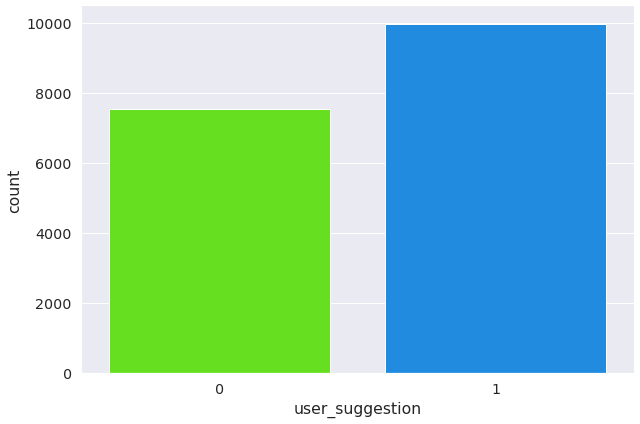

In [5]:
sns.factorplot(x = "user_suggestion", data = df, kind = "count", size = 6, aspect = 1.5, palette = "gist_rainbow")
plt.show()

# Building the classifier


In [6]:
nlp = spacy.load("en_core_web_sm")
nlp.pipe_names

['tagger', 'parser', 'ner']

In [7]:
# adding the built-in textcat component to the pipleline

textcat = nlp.create_pipe("textcat", config = {"exclusive_classes": True, "architecture": "bow"})
nlp.add_pipe(textcat, last = True)
nlp.pipe_names

['tagger', 'parser', 'ner', 'textcat']

In [8]:
# adding labels to textcat

textcat.add_label("RECOMMENDED")
textcat.add_label("AVOID")

1

In [9]:
# converting the dataframe into a list of tuples
df["tuples"] = df.apply(lambda row: (row["user_review"], row["user_suggestion"]), axis = 1)
train = df["tuples"].tolist()
train[:10]

[("I'm scared and hearing creepy voices.  So I'll pause for a moment and write a review while I wait for my heart beat to return to atleast somewhat calmer times.  This game is adorable and creepy like my happy tree friends but with the graphics sceme of my childhood (but more bubble and 'clean').  Hello 1990's.What charactes there are (that isnot trying to kill me) were likable and a bit odd.  I did do a few noob things though, such as:Oh look a class room full of ghosts from dead children, lets shine my flashlight on them and stand there staring at them..Or, hmm creepy music, I'll turn around and see if I can see what's chasing me.Never before in a game have I been this afraid of finding a locked door.",
  1),
 ("Best game, more better than Sam Pepper's YouTube account. 10/10What you'll need to play:A computerSome extra pants.Pros:Scary as hell.Fun.Adventure.Spooky.Did I forgot to mention that its scary as hell?You'll get more pants/briefs in your wardrobe.Time consuming if you're bo

In [10]:
import random

def load_data(limit = 0, split = 0.8):
  train_data = train
  random.shuffle(train_data)
  texts, labels = zip(*train_data)
  # get category for each review
  cats = [{"RECOMMENDED": bool(y), "AVOID": not bool(y)} for y in labels]

  # splitting the training and evaluation data
  split = int(len(train_data) * split)
  return(texts[:split], cats[:split]), (texts[split:], cats[split])


n_texts = 0.8 * len(train)

# calling the load_data function
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit = n_texts)

# processing the final format of the training data
train_data = list(zip(train_texts, [{"cats": cats} for cats in train_cats]))
train_data[:10]


[("I love the game. While I dont got many hours on pc, I have played for what I think is over 600 hours on console. This game is amazing. Games now are dedicated to money and providing little content. This game just ♥♥♥♥ing blows my mind with the levels of intensity of these battles. I would love to see this game be tooken by a big company and revived. This game isn't shown the love that it used to. Install this game and don't stop playing it. ♥♥♥♥ing endless gameplay.",
  {'cats': {'AVOID': False, 'RECOMMENDED': True}}),
 ('Early Access ReviewOmgThis game shouldn\'t even be on steam but in some "Beta Section".This game isn\'t finished at ALL!I hope it was a combination of CS1.6 and Call of Duty, because it look like it.This game could be awesome but it\'s really trash. Sound is bugged, the footsteps sound like everyone had only 1 leg and legs out of wood. The ADS is also trash because it\'s click to ADS not "HOLD TO ADS" i hate the hold to ADS function, never use it. Many times i wond

In [13]:
# training the model

from spacy.util import minibatch, compounding

n_iterations = 10

# disabling other components
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "textcat"]
with nlp.disable_pipes(*other_pipes):
  optimizer = nlp.begin_training()

  print("training..")

  for i in range(n_iterations):
    losses = {} # a type of dict, and takes an optional record of the loss during training
    batches = minibatch(train_data, size = compounding(4.,32.,1.001))

    for batch in batches:
      texts, annotations = zip(*batch)
      nlp.update(texts, annotations, sgd = optimizer, drop = 0.2, losses = losses)
    
print("training complete")

training..


In [23]:
# testing the model

review = "This game is incredible!!"
doc = nlp(review)
doc.cats

{'AVOID': 0.1404338926076889, 'RECOMMENDED': 0.8595660924911499}